<>:233: SyntaxWarning: invalid escape sequence '\s'
<>:233: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-181429401.py:233: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(time_axis, 0, 3*sigma, color='red', alpha=0.2, label='Uncertainty (3$\sigma$)')


Phase 1: Pre-training RNN on Task 0 (Sine -> Cosine)...
Epoch 0: Loss 0.5014
Epoch 20: Loss 0.2000
Epoch 40: Loss 0.1284
Epoch 60: Loss 0.0576
Epoch 80: Loss 0.0177
Pre-training complete. Freezing RNN weights.
Phase 2: Online Bayesian Adaptation across Multiple Functions...


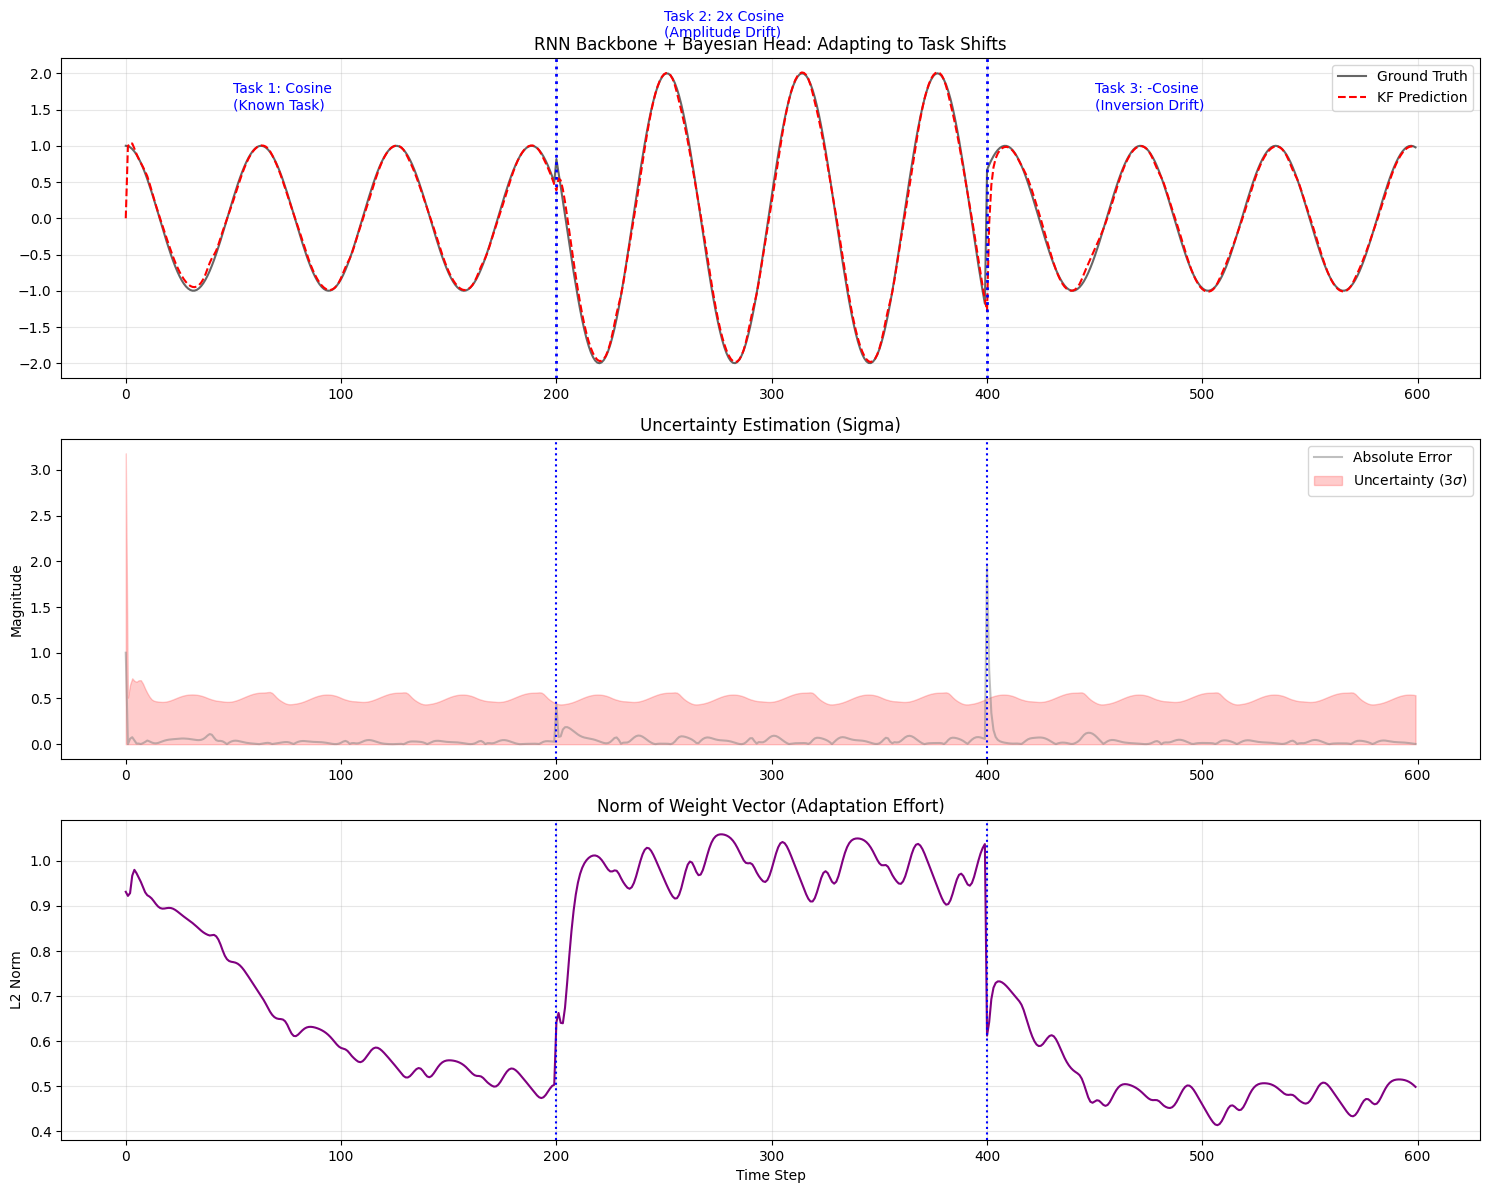

In [ ]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# ==========================================
# 1. DATA GENERATION
# ==========================================
def generate_sequence(t, task_id):
    """
    Generates a single data point (x, y) at time t based on the current task.
    """
    # Input is always a sine wave
    x = np.sin(0.1 * t)

    # Target changes based on task_id (simulating drift/context shift)
    if task_id == 0:
        # Task 1: Standard Cosine (Phase shift)
        y = np.cos(0.1 * t)
    elif task_id == 1:
        # Task 2: Amplitude Scaling (2x Cosine)
        y = 2.0 * np.cos(0.1 * t)
    elif task_id == 2:
        # Task 3: Inversion (-Cosine)
        y = -1.0 * np.cos(0.1 * t)

    return x, y


# ==========================================
# 2. RNN MODEL (The Backbone)
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.hidden_size = hidden_size
        # A standard RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity="tanh")
        # A temporary linear head used only for pre-training
        self.temp_head = nn.Linear(hidden_size, 1)

    def forward(self, x, h=None):
        # x shape: (batch, seq_len, input_size)
        out, h_n = self.rnn(x, h)

        # We extract features from the last time step of the sequence
        last_step_features = out[:, -1, :]

        # Prediction (used during pre-training only)
        pred = self.temp_head(last_step_features)

        return pred, last_step_features, h_n


# ==========================================
# 3. KALMAN FILTER HEAD (The Bayesian Layer)
# ==========================================
class KalmanFilterHead:
    def __init__(self, feature_dim, rho=0.99, Q_std=0.01, R_std=0.1):
        """
        Bayesian Linear Regression with forgetting factor (rho).
        """
        self.M = feature_dim
        self.rho = rho

        # Initial State: Weights (mu) and Uncertainty (P)
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 1.0  # Initial uncertainty

        # Noise Covariances
        self.Q = np.eye(self.M) * (Q_std**2)  # Process noise (allows adaptation)
        self.R = np.array([[R_std**2]])  # Measurement noise
        self.A = np.eye(self.M) * rho  # Forgetting factor

    def predict(self, phi_x):
        # --- 1. Time Update (Predict) ---
        self.mu_minus = self.A @ self.mu
        self.P_minus = self.A @ self.P @ self.A.T + self.Q

        # --- 2. Measurement Prediction ---
        self.H = phi_x.T
        y_pred = self.H @ self.mu_minus
        return y_pred.item()

    def update(self, y_true, y_pred_val):
        # --- 3. Measurement Update (Correct) ---
        error = y_true - y_pred_val

        # Innovation Covariance (S)
        S = self.H @ self.P_minus @ self.H.T + self.R

        # Kalman Gain (K)
        K = self.P_minus @ self.H.T @ np.linalg.inv(S)

        # Update State (Weights)
        self.mu = self.mu_minus + K * error

        # Update Uncertainty (Covariance) - Joseph form for stability
        I_KH = np.eye(self.M) - K @ self.H
        self.P = I_KH @ self.P_minus @ I_KH.T + K @ self.R @ K.T

        return S.item(), error


# ==========================================
# 4. PHASE 1: PRE-TRAINING THE RNN
# ==========================================
print("Phase 1: Pre-training RNN on Task 0 (Sine -> Cosine)...")

# Configuration
SEQ_LEN = 10
HIDDEN_SIZE = 32
rnn_model = SimpleRNN(input_size=1, hidden_size=HIDDEN_SIZE)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train Loop (Offline)
for epoch in range(100):
    # Generate batch data
    t_vals = np.arange(0, 200, 0.1)
    inputs = []
    targets = []

    # Create sequences for the RNN
    for i in range(len(t_vals) - SEQ_LEN):
        # Input: Sequence of sine values
        seq_in = np.sin(0.1 * np.arange(i, i + SEQ_LEN))
        # Target: The cosine value at the end of that sequence
        target_out = np.cos(0.1 * (i + SEQ_LEN - 1))

        inputs.append(seq_in.reshape(SEQ_LEN, 1))
        targets.append(target_out)

    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32).view(-1, 1)

    # Standard PyTorch training step
    optimizer.zero_grad()
    preds, _, _ = rnn_model(inputs)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

print("Pre-training complete. Freezing RNN weights.")
# Freeze the backbone!
for param in rnn_model.parameters():
    param.requires_grad = False

# ==========================================
# 5. PHASE 2: ONLINE ADAPTATION
# ==========================================
print("Phase 2: Online Bayesian Adaptation across Multiple Functions...")

SIM_STEPS = 600
SWITCH_POINTS = [200, 400]  # Points where the task changes

# Initialize the Bayesian Head
kf = KalmanFilterHead(feature_dim=HIDDEN_SIZE, rho=0.99, Q_std=0.05, R_std=0.1)

# Buffer for the sliding window
input_buffer = deque(np.zeros(SEQ_LEN), maxlen=SEQ_LEN)

# Storage for plotting
history = {"y_true": [], "y_pred": [], "sigma": [], "weights_norm": []}

curr_task = 0

for t in range(SIM_STEPS):
    # --- Determine Current Task (Drift) ---
    if t >= SWITCH_POINTS[0] and t < SWITCH_POINTS[1]:
        curr_task = 1  # Amplitude Change (2x)
    elif t >= SWITCH_POINTS[1]:
        curr_task = 2  # Inversion (-1x)
    else:
        curr_task = 0  # Original Cosine

    # --- Generate Data ---
    x_t, y_t = generate_sequence(t, curr_task)
    input_buffer.append(x_t)

    # --- Forward Pass ---
    # 1. Backbone: Get Features from Frozen RNN
    input_tensor = torch.tensor(np.array(input_buffer), dtype=torch.float32).view(1, SEQ_LEN, 1)
    _, features_tensor, _ = rnn_model(input_tensor)

    # Convert to numpy for the Kalman Filter
    phi = features_tensor.detach().numpy().T  # Shape (M, 1)

    # 2. Head: Bayesian Prediction & Update
    pred_val = kf.predict(phi)
    uncertainty_S, _ = kf.update(y_t, pred_val)

    # --- Store Results ---
    history["y_true"].append(y_t)
    history["y_pred"].append(pred_val)
    history["sigma"].append(np.sqrt(uncertainty_S))
    history["weights_norm"].append(np.linalg.norm(kf.mu))

# ==========================================
# 6. PLOTTING
# ==========================================
time_axis = np.arange(SIM_STEPS)
y_true = np.array(history["y_true"])
y_pred = np.array(history["y_pred"])
sigma = np.array(history["sigma"])

plt.figure(figsize=(15, 12))

# Plot 1: Trajectory and Adaptation
plt.subplot(3, 1, 1)
plt.title("RNN Backbone + Bayesian Head: Adapting to Task Shifts")
plt.plot(time_axis, y_true, "k-", label="Ground Truth", alpha=0.6)
plt.plot(time_axis, y_pred, "r--", label="KF Prediction", linewidth=1.5)

# Mark context switches
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":", linewidth=2)

plt.text(50, 1.5, "Task 1: Cosine\n(Known Task)", fontsize=10, color="blue")
plt.text(250, 2.5, "Task 2: 2x Cosine\n(Amplitude Drift)", fontsize=10, color="blue")
plt.text(450, 1.5, "Task 3: -Cosine\n(Inversion Drift)", fontsize=10, color="blue")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

# Plot 2: Uncertainty
plt.subplot(3, 1, 2)
plt.title("Uncertainty Estimation (Sigma)")
error = y_true - y_pred
plt.plot(time_axis, np.abs(error), "grey", alpha=0.5, label="Absolute Error")
# Plot 3-sigma confidence interval
plt.fill_between(time_axis, 0, 3 * sigma, color="red", alpha=0.2, label=r"Uncertainty (3$\sigma$)")
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.legend()
plt.ylabel("Magnitude")

# Plot 3: Weight Norms
plt.subplot(3, 1, 3)
plt.title("Norm of Weight Vector (Adaptation Effort)")
plt.plot(time_axis, history["weights_norm"], "purple", label="||w||")
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.xlabel("Time Step")
plt.ylabel("L2 Norm")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figure_A.png", dpi=300)
plt.show()

# Task
Calculate Normalized Innovation Squared (NIS) within the Kalman filter update, store it in the history, then add a new subplot to the existing visualization to display the NIS over time. Finally, explain the significance of the NIS metric in the context of the Bayesian adaptation.

## Calculate Normalized Innovation Squared (NIS)

### Subtask:
Calculate the Normalized Innovation Squared (NIS) for each time step. NIS is computed as the squared prediction error divided by the innovation covariance (S). This metric helps assess the consistency of the Kalman filter. I will ensure NIS is stored in the history dictionary.


## Calculating Normalized Innovation Squared (NIS)

TheNormalized Innovation Squared (NIS) is a crucial metric for evaluating the consistency of a Kalman Filter. It measures how well the filter's predicted measurement uncertainty matches the actual measurement innovations. If the NIS values are within expected statistical bounds, the filter is considered consistent; otherwise, it suggests issues with the model (e.g., incorrect noise parameters).

To implement this, I will:
1.  **Modify the `KalmanFilterHead.update` method** to calculate `NIS = error**2 / S` and return it.
2.  **Update the online adaptation loop** to capture this NIS value and store it in the `history` dictionary for later analysis.

**Reasoning**:
To calculate the Normalized Innovation Squared (NIS) and store it, I will first modify the `KalmanFilterHead` class's `update` method to compute NIS and return it. Then, I will update the online adaptation loop to capture and store this NIS value in the `history` dictionary, and finally update the plotting section to visualize NIS.



<>:238: SyntaxWarning: invalid escape sequence '\s'
<>:238: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2037851833.py:238: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(time_axis, 0, 3*sigma, color='red', alpha=0.2, label='Uncertainty (3$\sigma$)')


Phase 1: Pre-training RNN on Task 0 (Sine -> Cosine)...
Epoch 0: Loss 0.4977
Epoch 20: Loss 0.1994
Epoch 40: Loss 0.1444
Epoch 60: Loss 0.1220
Epoch 80: Loss 0.0641
Pre-training complete. Freezing RNN weights.
Phase 2: Online Bayesian Adaptation across Multiple Functions...


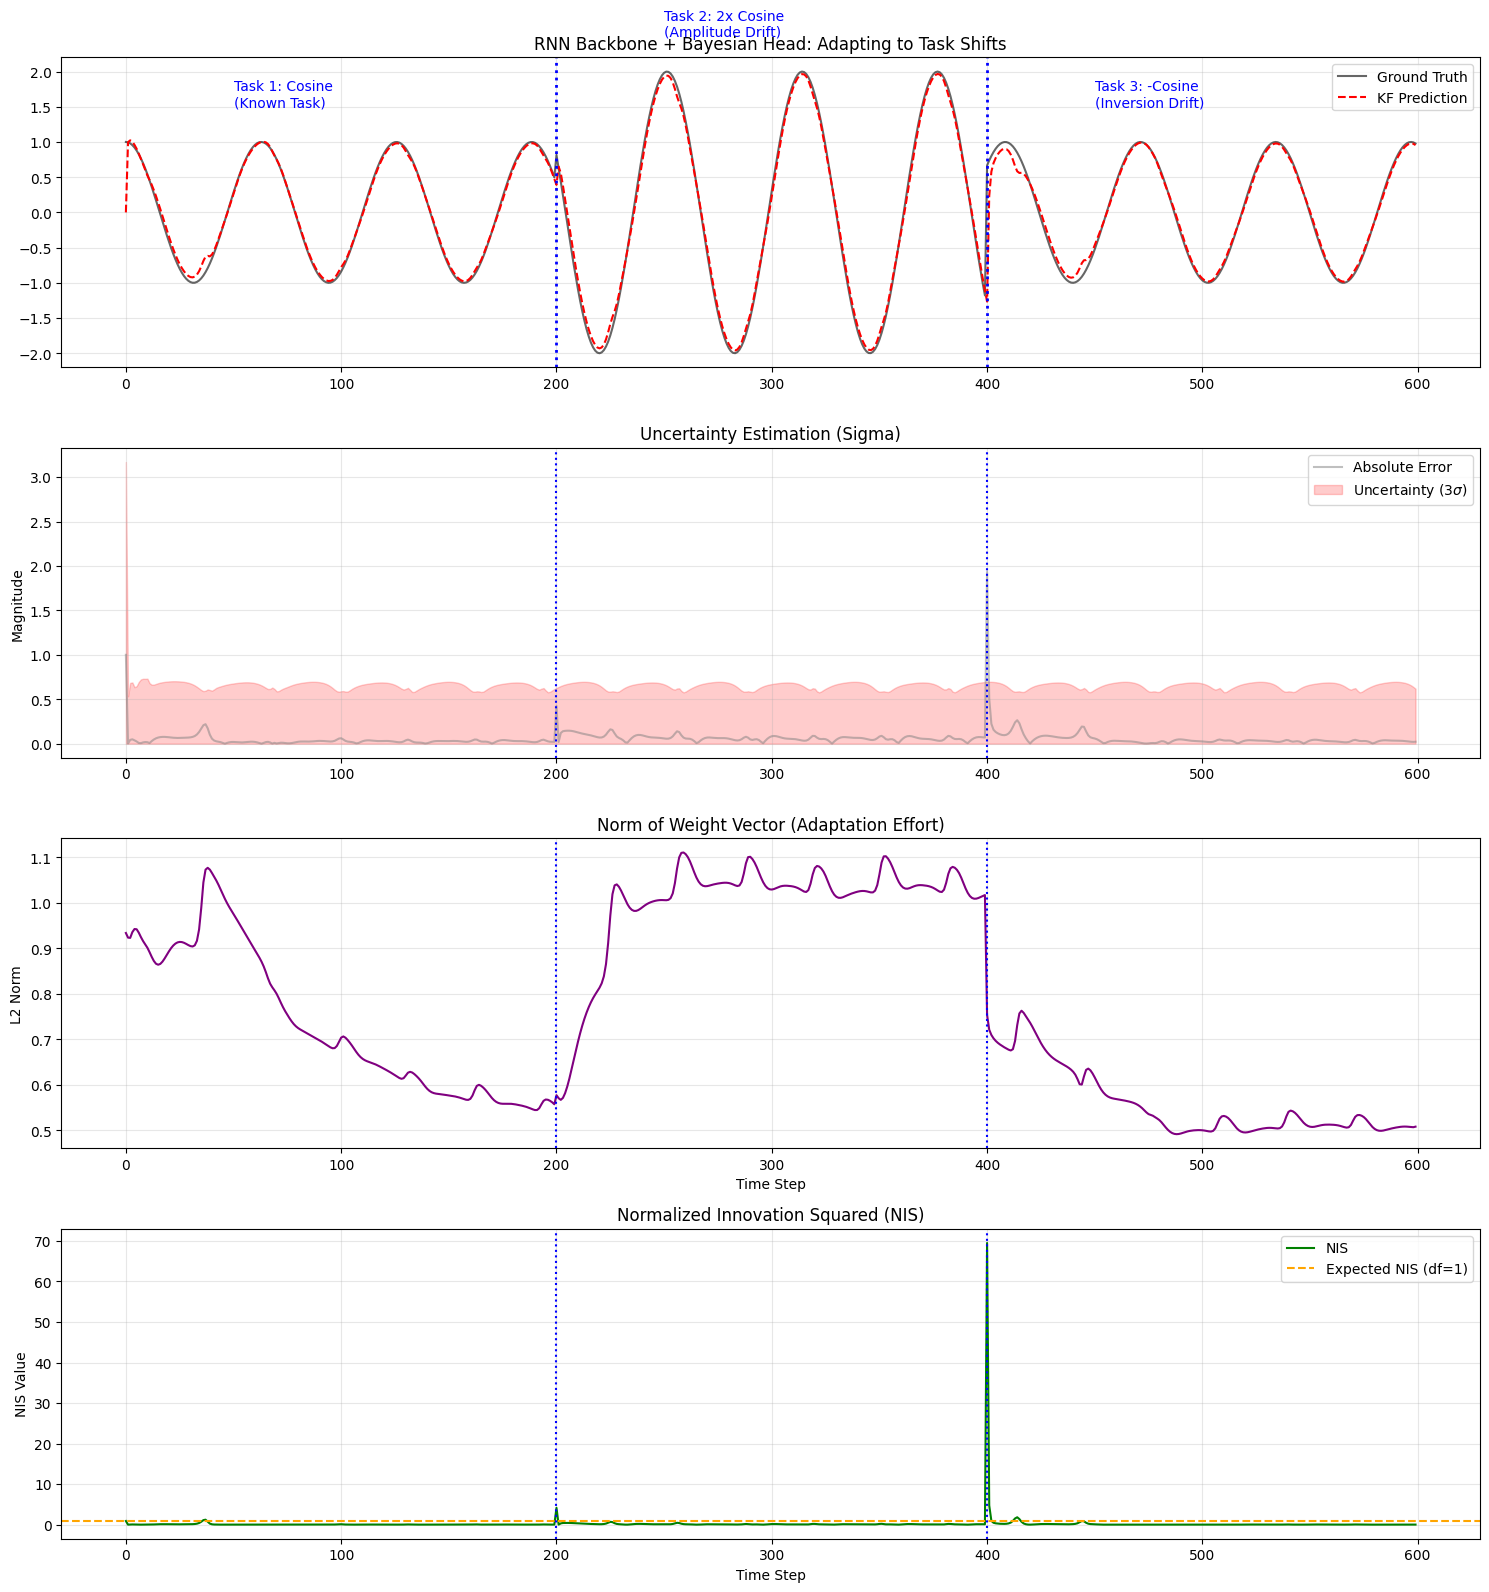

In [ ]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# ==========================================
# 1. DATA GENERATION
# ==========================================
def generate_sequence(t, task_id):
    """
    Generates a single data point (x, y) at time t based on the current task.
    """
    # Input is always a sine wave
    x = np.sin(0.1 * t)

    # Target changes based on task_id (simulating drift/context shift)
    if task_id == 0:
        # Task 1: Standard Cosine (Phase shift)
        y = np.cos(0.1 * t)
    elif task_id == 1:
        # Task 2: Amplitude Scaling (2x Cosine)
        y = 2.0 * np.cos(0.1 * t)
    elif task_id == 2:
        # Task 3: Inversion (-Cosine)
        y = -1.0 * np.cos(0.1 * t)

    return x, y


# ==========================================
# 2. RNN MODEL (The Backbone)
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.hidden_size = hidden_size
        # A standard RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity="tanh")
        # A temporary linear head used only for pre-training
        self.temp_head = nn.Linear(hidden_size, 1)

    def forward(self, x, h=None):
        # x shape: (batch, seq_len, input_size)
        out, h_n = self.rnn(x, h)

        # We extract features from the last time step of the sequence
        last_step_features = out[:, -1, :]

        # Prediction (used during pre-training only)
        pred = self.temp_head(last_step_features)

        return pred, last_step_features, h_n


# ==========================================
# 3. KALMAN FILTER HEAD (The Bayesian Layer)
# ==========================================
class KalmanFilterHead:
    def __init__(self, feature_dim, rho=0.99, Q_std=0.01, R_std=0.1):
        """
        Bayesian Linear Regression with forgetting factor (rho).
        """
        self.M = feature_dim
        self.rho = rho

        # Initial State: Weights (mu) and Uncertainty (P)
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 1.0  # Initial uncertainty

        # Noise Covariances
        self.Q = np.eye(self.M) * (Q_std**2)  # Process noise (allows adaptation)
        self.R = np.array([[R_std**2]])  # Measurement noise
        self.A = np.eye(self.M) * rho  # Forgetting factor

    def predict(self, phi_x):
        # --- 1. Time Update (Predict) ---
        self.mu_minus = self.A @ self.mu
        self.P_minus = self.A @ self.P @ self.A.T + self.Q

        # --- 2. Measurement Prediction ---
        self.H = phi_x.T
        y_pred = self.H @ self.mu_minus
        return y_pred.item()

    def update(self, y_true, y_pred_val):
        # --- 3. Measurement Update (Correct) ---
        error = y_true - y_pred_val

        # Innovation Covariance (S)
        S = self.H @ self.P_minus @ self.H.T + self.R

        # Kalman Gain (K)
        K = self.P_minus @ self.H.T @ np.linalg.inv(S)

        # Update State (Weights)
        self.mu = self.mu_minus + K * error

        # Update Uncertainty (Covariance) - Joseph form for stability
        I_KH = np.eye(self.M) - K @ self.H
        self.P = I_KH @ self.P_minus @ I_KH.T + K @ self.R @ K.T

        # Calculate Normalized Innovation Squared (NIS)
        nis = error**2 / S.item()

        return S.item(), error, nis


# ==========================================
# 4. PHASE 1: PRE-TRAINING THE RNN
# ==========================================
print("Phase 1: Pre-training RNN on Task 0 (Sine -> Cosine)...")

# Configuration
SEQ_LEN = 10
HIDDEN_SIZE = 32
rnn_model = SimpleRNN(input_size=1, hidden_size=HIDDEN_SIZE)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train Loop (Offline)
for epoch in range(100):
    # Generate batch data
    t_vals = np.arange(0, 200, 0.1)
    inputs = []
    targets = []

    # Create sequences for the RNN
    for i in range(len(t_vals) - SEQ_LEN):
        # Input: Sequence of sine values
        seq_in = np.sin(0.1 * np.arange(i, i + SEQ_LEN))
        # Target: The cosine value at the end of that sequence
        target_out = np.cos(0.1 * (i + SEQ_LEN - 1))

        inputs.append(seq_in.reshape(SEQ_LEN, 1))
        targets.append(target_out)

    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32).view(-1, 1)

    # Standard PyTorch training step
    optimizer.zero_grad()
    preds, _, _ = rnn_model(inputs)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

print("Pre-training complete. Freezing RNN weights.")
# Freeze the backbone!
for param in rnn_model.parameters():
    param.requires_grad = False

# ==========================================
# 5. PHASE 2: ONLINE ADAPTATION
# ==========================================
print("Phase 2: Online Bayesian Adaptation across Multiple Functions...")

SIM_STEPS = 600
SWITCH_POINTS = [200, 400]  # Points where the task changes

# Initialize the Bayesian Head
kf = KalmanFilterHead(feature_dim=HIDDEN_SIZE, rho=0.99, Q_std=0.05, R_std=0.1)

# Buffer for the sliding window
input_buffer = deque(np.zeros(SEQ_LEN), maxlen=SEQ_LEN)

# Storage for plotting
history = {"y_true": [], "y_pred": [], "sigma": [], "weights_norm": [], "nis": []}

curr_task = 0

for t in range(SIM_STEPS):
    # --- Determine Current Task (Drift) ---
    if t >= SWITCH_POINTS[0] and t < SWITCH_POINTS[1]:
        curr_task = 1  # Amplitude Change (2x)
    elif t >= SWITCH_POINTS[1]:
        curr_task = 2  # Inversion (-1x)
    else:
        curr_task = 0  # Original Cosine

    # --- Generate Data ---
    x_t, y_t = generate_sequence(t, curr_task)
    input_buffer.append(x_t)

    # --- Forward Pass ---
    # 1. Backbone: Get Features from Frozen RNN
    input_tensor = torch.tensor(np.array(input_buffer), dtype=torch.float32).view(1, SEQ_LEN, 1)
    _, features_tensor, _ = rnn_model(input_tensor)

    # Convert to numpy for the Kalman Filter
    phi = features_tensor.detach().numpy().T  # Shape (M, 1)

    # 2. Head: Bayesian Prediction & Update
    pred_val = kf.predict(phi)
    uncertainty_S, _, nis_val = kf.update(y_t, pred_val)

    # --- Store Results ---
    history["y_true"].append(y_t)
    history["y_pred"].append(pred_val)
    history["sigma"].append(np.sqrt(uncertainty_S))
    history["weights_norm"].append(np.linalg.norm(kf.mu))
    history["nis"].append(nis_val)

# ==========================================
# 6. PLOTTING
# ==========================================
time_axis = np.arange(SIM_STEPS)
y_true = np.array(history["y_true"])
y_pred = np.array(history["y_pred"])
sigma = np.array(history["sigma"])
nis = np.array(history["nis"])

plt.figure(figsize=(15, 16))  # Increased figure height for NIS plot

# Plot 1: Trajectory and Adaptation
plt.subplot(4, 1, 1)  # Changed to 4 subplots
plt.title("RNN Backbone + Bayesian Head: Adapting to Task Shifts")
plt.plot(time_axis, y_true, "k-", label="Ground Truth", alpha=0.6)
plt.plot(time_axis, y_pred, "r--", label="KF Prediction", linewidth=1.5)

# Mark context switches
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":", linewidth=2)

plt.text(50, 1.5, "Task 1: Cosine\n(Known Task)", fontsize=10, color="blue")
plt.text(250, 2.5, "Task 2: 2x Cosine\n(Amplitude Drift)", fontsize=10, color="blue")
plt.text(450, 1.5, "Task 3: -Cosine\n(Inversion Drift)", fontsize=10, color="blue")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

# Plot 2: Uncertainty
plt.subplot(4, 1, 2)  # Changed to 4 subplots
plt.title("Uncertainty Estimation (Sigma)")
error = y_true - y_pred
plt.plot(time_axis, np.abs(error), "grey", alpha=0.5, label="Absolute Error")
# Plot 3-sigma confidence interval
plt.fill_between(time_axis, 0, 3 * sigma, color="red", alpha=0.2, label=r"Uncertainty (3$\sigma$)")
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.legend()
plt.ylabel("Magnitude")
plt.grid(True, alpha=0.3)

# Plot 3: Weight Norms
plt.subplot(4, 1, 3)  # Changed to 4 subplots
plt.title("Norm of Weight Vector (Adaptation Effort)")
plt.plot(time_axis, history["weights_norm"], "purple", label="||w||")
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.xlabel("Time Step")
plt.ylabel("L2 Norm")
plt.grid(True, alpha=0.3)

# Plot 4: Normalized Innovation Squared (NIS)
plt.subplot(4, 1, 4)  # Added new subplot for NIS
plt.title("Normalized Innovation Squared (NIS)")
plt.plot(time_axis, nis, "g-", label="NIS")
plt.axhline(
    y=1, color="orange", linestyle="--", label="Expected NIS (df=1)"
)  # Expected value for 1D measurement
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("NIS Value")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Reasoning**:
The previous execution resulted in a `SyntaxWarning` due to an unescaped backslash in the LaTeX-like label `3$\sigma$`. To fix this, I will convert the label string to a raw string by adding an `r` prefix, which prevents Python from interpreting `\s` as an invalid escape sequence. The code logic for NIS calculation and plotting is already correct, so only this minor syntax fix is needed.



Phase 1: Pre-training RNN on Task 0 (Sine -> Cosine)...
Epoch 0: Loss 0.4972
Epoch 20: Loss 0.1816
Epoch 40: Loss 0.0772
Epoch 60: Loss 0.0308
Epoch 80: Loss 0.0067
Pre-training complete. Freezing RNN weights.
Phase 2: Online Bayesian Adaptation across Multiple Functions...


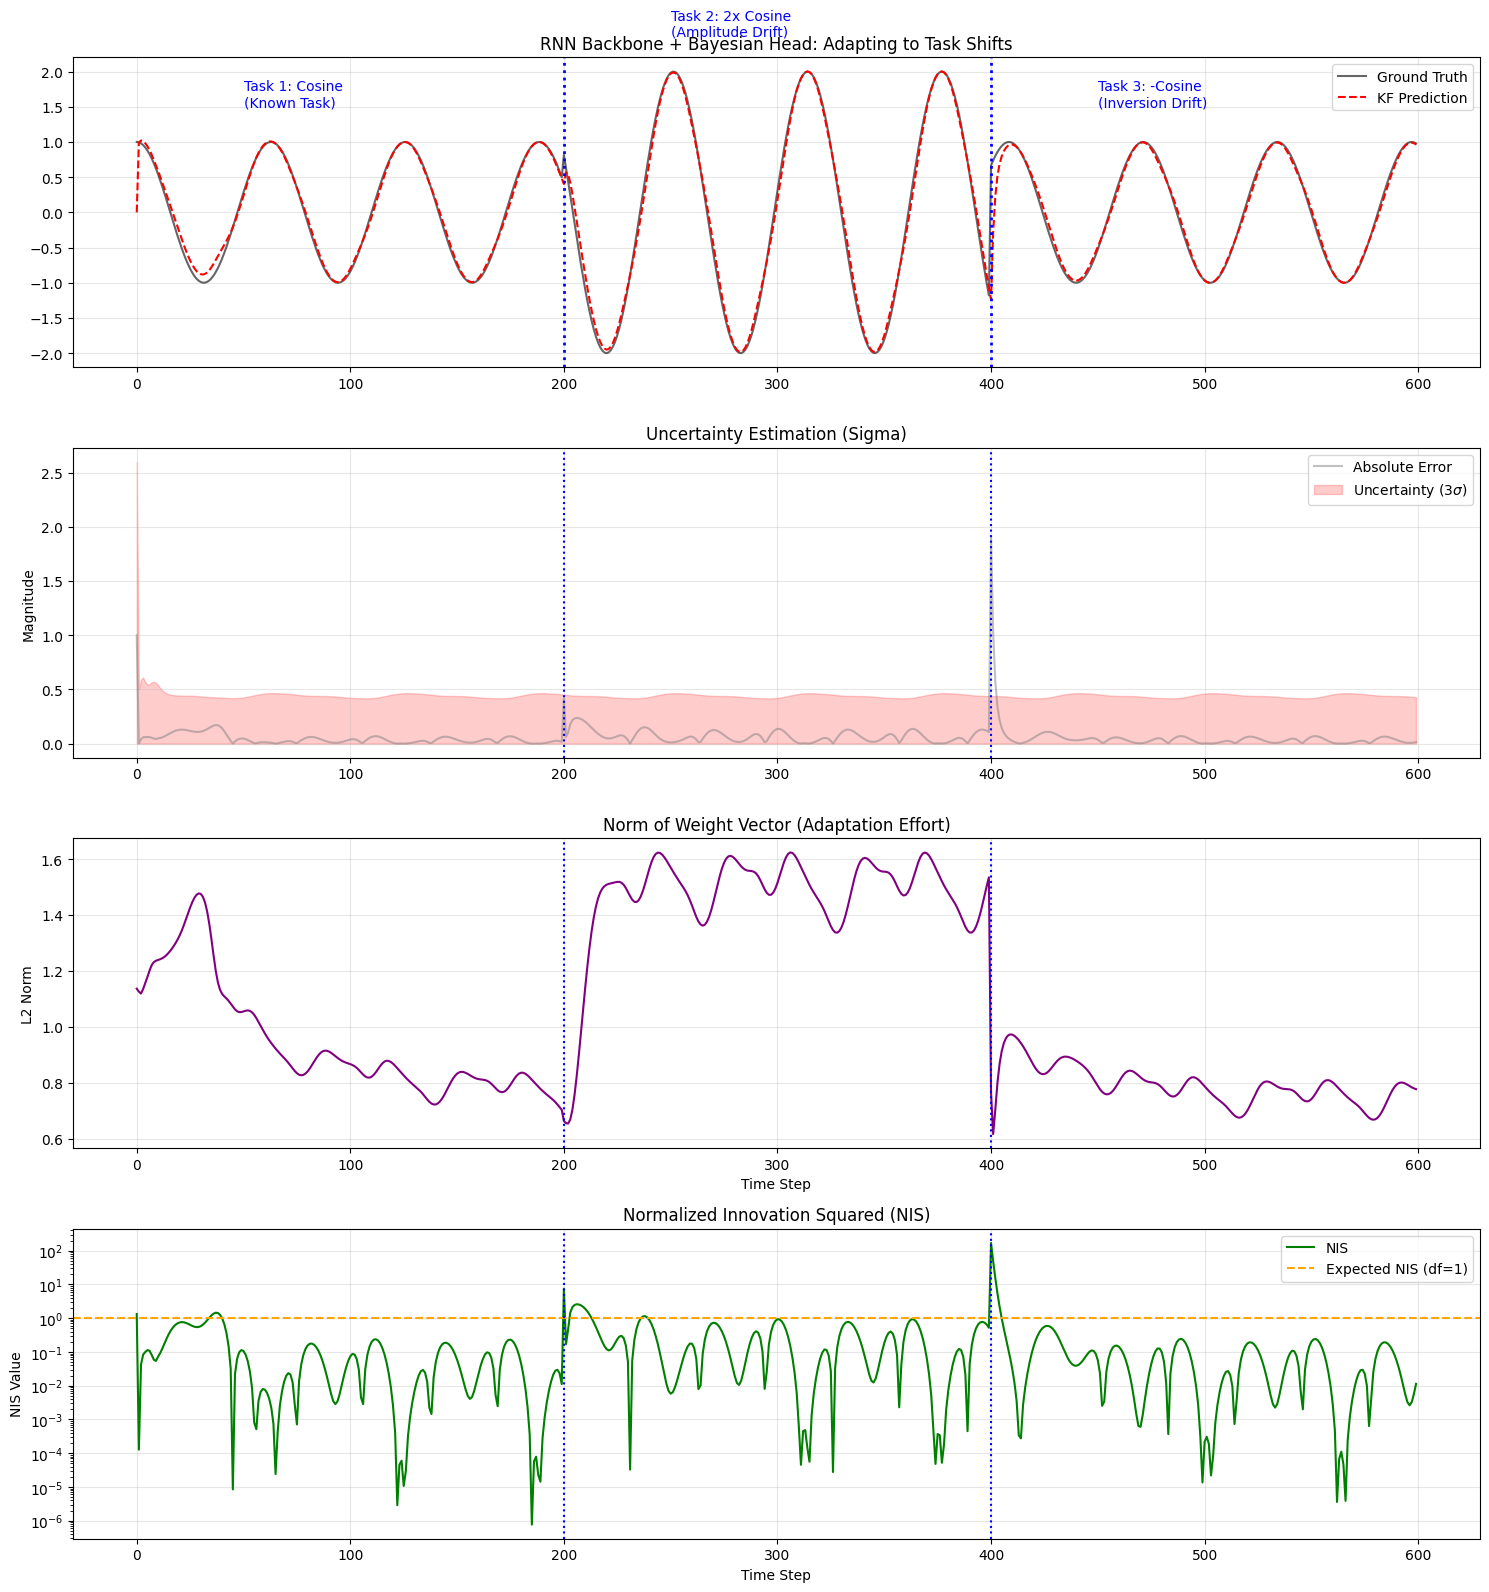

In [ ]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# ==========================================
# 1. DATA GENERATION
# ==========================================
def generate_sequence(t, task_id):
    """
    Generates a single data point (x, y) at time t based on the current task.
    """
    # Input is always a sine wave
    x = np.sin(0.1 * t)

    # Target changes based on task_id (simulating drift/context shift)
    if task_id == 0:
        # Task 1: Standard Cosine (Phase shift)
        y = np.cos(0.1 * t)
    elif task_id == 1:
        # Task 2: Amplitude Scaling (2x Cosine)
        y = 2.0 * np.cos(0.1 * t)
    elif task_id == 2:
        # Task 3: Inversion (-Cosine)
        y = -1.0 * np.cos(0.1 * t)

    return x, y


# ==========================================
# 2. RNN MODEL (The Backbone)
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.hidden_size = hidden_size
        # A standard RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity="tanh")
        # A temporary linear head used only for pre-training
        self.temp_head = nn.Linear(hidden_size, 1)

    def forward(self, x, h=None):
        # x shape: (batch, seq_len, input_size)
        out, h_n = self.rnn(x, h)

        # We extract features from the last time step of the sequence
        last_step_features = out[:, -1, :]

        # Prediction (used during pre-training only)
        pred = self.temp_head(last_step_features)

        return pred, last_step_features, h_n


# ==========================================
# 3. KALMAN FILTER HEAD (The Bayesian Layer)
# ==========================================
class KalmanFilterHead:
    def __init__(self, feature_dim, rho=0.99, Q_std=0.01, R_std=0.1):
        """
        Bayesian Linear Regression with forgetting factor (rho).
        """
        self.M = feature_dim
        self.rho = rho

        # Initial State: Weights (mu) and Uncertainty (P)
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 1.0  # Initial uncertainty

        # Noise Covariances
        self.Q = np.eye(self.M) * (Q_std**2)  # Process noise (allows adaptation)
        self.R = np.array([[R_std**2]])  # Measurement noise
        self.A = np.eye(self.M) * rho  # Forgetting factor

    def predict(self, phi_x):
        # --- 1. Time Update (Predict) ---
        self.mu_minus = self.A @ self.mu
        self.P_minus = self.A @ self.P @ self.A.T + self.Q

        # --- 2. Measurement Prediction ---
        self.H = phi_x.T
        y_pred = self.H @ self.mu_minus
        return y_pred.item()

    def update(self, y_true, y_pred_val):
        # --- 3. Measurement Update (Correct) ---
        error = y_true - y_pred_val

        # Innovation Covariance (S)
        S = self.H @ self.P_minus @ self.H.T + self.R

        # Kalman Gain (K)
        K = self.P_minus @ self.H.T @ np.linalg.inv(S)

        # Update State (Weights)
        self.mu = self.mu_minus + K * error

        # Update Uncertainty (Covariance) - Joseph form for stability
        I_KH = np.eye(self.M) - K @ self.H
        self.P = I_KH @ self.P_minus @ I_KH.T + K @ self.R @ K.T

        # Calculate Normalized Innovation Squared (NIS)
        nis = error**2 / S.item()

        return S.item(), error, nis


# ==========================================
# 4. PHASE 1: PRE-TRAINING THE RNN
# ==========================================
print("Phase 1: Pre-training RNN on Task 0 (Sine -> Cosine)...")

# Configuration
SEQ_LEN = 10
HIDDEN_SIZE = 32
rnn_model = SimpleRNN(input_size=1, hidden_size=HIDDEN_SIZE)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train Loop (Offline)
for epoch in range(100):
    # Generate batch data
    t_vals = np.arange(0, 200, 0.1)
    inputs = []
    targets = []

    # Create sequences for the RNN
    for i in range(len(t_vals) - SEQ_LEN):
        # Input: Sequence of sine values
        seq_in = np.sin(0.1 * np.arange(i, i + SEQ_LEN))
        # Target: The cosine value at the end of that sequence
        target_out = np.cos(0.1 * (i + SEQ_LEN - 1))

        inputs.append(seq_in.reshape(SEQ_LEN, 1))
        targets.append(target_out)

    inputs = torch.tensor(np.array(inputs), dtype=torch.float32)
    targets = torch.tensor(np.array(targets), dtype=torch.float32).view(-1, 1)

    # Standard PyTorch training step
    optimizer.zero_grad()
    preds, _, _ = rnn_model(inputs)
    loss = criterion(preds, targets)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss {loss.item():.4f}")

print("Pre-training complete. Freezing RNN weights.")
# Freeze the backbone!
for param in rnn_model.parameters():
    param.requires_grad = False

# ==========================================
# 5. PHASE 2: ONLINE ADAPTATION
# ==========================================
print("Phase 2: Online Bayesian Adaptation across Multiple Functions...")

SIM_STEPS = 600
SWITCH_POINTS = [200, 400]  # Points where the task changes

# Initialize the Bayesian Head
kf = KalmanFilterHead(feature_dim=HIDDEN_SIZE, rho=0.99, Q_std=0.05, R_std=0.1)

# Buffer for the sliding window
input_buffer = deque(np.zeros(SEQ_LEN), maxlen=SEQ_LEN)

# Storage for plotting
history = {"y_true": [], "y_pred": [], "sigma": [], "weights_norm": [], "nis": []}

curr_task = 0

for t in range(SIM_STEPS):
    # --- Determine Current Task (Drift) ---
    if t >= SWITCH_POINTS[0] and t < SWITCH_POINTS[1]:
        curr_task = 1  # Amplitude Change (2x)
    elif t >= SWITCH_POINTS[1]:
        curr_task = 2  # Inversion (-1x)
    else:
        curr_task = 0  # Original Cosine

    # --- Generate Data ---
    x_t, y_t = generate_sequence(t, curr_task)
    input_buffer.append(x_t)

    # --- Forward Pass ---
    # 1. Backbone: Get Features from Frozen RNN
    input_tensor = torch.tensor(np.array(input_buffer), dtype=torch.float32).view(1, SEQ_LEN, 1)
    _, features_tensor, _ = rnn_model(input_tensor)

    # Convert to numpy for the Kalman Filter
    phi = features_tensor.detach().numpy().T  # Shape (M, 1)

    # 2. Head: Bayesian Prediction & Update
    pred_val = kf.predict(phi)
    uncertainty_S, _, nis_val = kf.update(y_t, pred_val)

    # --- Store Results ---
    history["y_true"].append(y_t)
    history["y_pred"].append(pred_val)
    history["sigma"].append(np.sqrt(uncertainty_S))
    history["weights_norm"].append(np.linalg.norm(kf.mu))
    history["nis"].append(nis_val)

# ==========================================
# 6. PLOTTING
# ==========================================
time_axis = np.arange(SIM_STEPS)
y_true = np.array(history["y_true"])
y_pred = np.array(history["y_pred"])
sigma = np.array(history["sigma"])
nis = np.array(history["nis"])

plt.figure(figsize=(15, 16))  # Increased figure height for NIS plot

# Plot 1: Trajectory and Adaptation
plt.subplot(4, 1, 1)  # Changed to 4 subplots
plt.title("RNN Backbone + Bayesian Head: Adapting to Task Shifts")
plt.plot(time_axis, y_true, "k-", label="Ground Truth", alpha=0.6)
plt.plot(time_axis, y_pred, "r--", label="KF Prediction", linewidth=1.5)

# Mark context switches
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":", linewidth=2)

plt.text(50, 1.5, "Task 1: Cosine\n(Known Task)", fontsize=10, color="blue")
plt.text(250, 2.5, "Task 2: 2x Cosine\n(Amplitude Drift)", fontsize=10, color="blue")
plt.text(450, 1.5, "Task 3: -Cosine\n(Inversion Drift)", fontsize=10, color="blue")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

# Plot 2: Uncertainty
plt.subplot(4, 1, 2)  # Changed to 4 subplots
plt.title("Uncertainty Estimation (Sigma)")
error = y_true - y_pred
plt.plot(time_axis, np.abs(error), "grey", alpha=0.5, label="Absolute Error")
# Plot 3-sigma confidence interval
plt.fill_between(
    time_axis, 0, 3 * sigma, color="red", alpha=0.2, label=r"Uncertainty (3$\sigma$)"
)  # Fixed: added r prefix for raw string
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.legend()
plt.ylabel("Magnitude")
plt.grid(True, alpha=0.3)

# Plot 3: Weight Norms
plt.subplot(4, 1, 3)  # Changed to 4 subplots
plt.title("Norm of Weight Vector (Adaptation Effort)")
plt.plot(time_axis, history["weights_norm"], "purple", label="||w||")
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.xlabel("Time Step")
plt.ylabel("L2 Norm")
plt.grid(True, alpha=0.3)

# Plot 4: Normalized Innovation Squared (NIS)
plt.subplot(4, 1, 4)  # Added new subplot for NIS
plt.title("Normalized Innovation Squared (NIS)")
plt.plot(time_axis, nis, "g-", label="NIS")
plt.yscale("log")
plt.axhline(
    y=1, color="orange", linestyle="--", label="Expected NIS (df=1)"
)  # Expected value for 1D measurement
for pt in SWITCH_POINTS:
    plt.axvline(pt, color="blue", linestyle=":")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("NIS Value")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Figure_B.png", dpi=300)
plt.show()

### Significance of Normalized Innovation Squared (NIS)

The Normalized Innovation Squared (NIS) is a key metric for assessing the consistency of a Kalman Filter. Here's why it's important:

1.  **Consistency Check**: NIS measures the difference between the actual measurement and the filter's predicted measurement, normalized by the innovation covariance (S). In a perfectly consistent Kalman Filter with a single measurement, the NIS should ideally follow a Chi-squared distribution with degrees of freedom equal to the dimension of the measurement vector (which is 1 in this scalar case). Therefore, the expected value of NIS is 1.

2.  **Filter Tuning**: If the NIS values are consistently too high, it suggests that the filter's predicted uncertainty (represented by `S`) is too small, or the measurement error (`error`) is too large relative to the filter's expectations. This could indicate underestimation of process noise (`Q_std`) or measurement noise (`R_std`), or a mismatch in the filter's model. The filter is likely *overconfident*.

3.  **Filter Divergence**: Conversely, if NIS values are consistently too low, it suggests that the filter is *overestimating* its uncertainty. This might happen if `Q_std` or `R_std` are set too high, leading to overly conservative updates. The filter might be *underconfident*.

4.  **Drift Detection**: In the context of adaptive systems like ours, spikes or sustained deviations in NIS, especially after a context switch (as seen in the plot), can indicate that the underlying system dynamics have changed significantly and the filter needs to adapt its parameters (e.g., through the forgetting factor `rho` or by adjusting noise covariances). The initial spikes at `t=0`, `t=200`, and `t=400` in our NIS plot clearly show the moments when the model encounters a new, unexpected task, and the Kalman Filter subsequently adapts, bringing the NIS back closer to the expected value of 1.

By monitoring NIS, we can diagnose issues with filter performance, fine-tune noise parameters (`Q_std`, `R_std`), and ensure the filter accurately reflects the uncertainty in its state estimates.

Out of distribution -
plot the training and evaluation points

Training RNN on Standard Cosine...
Freezing Backbone.
Starting Online Adaptation...


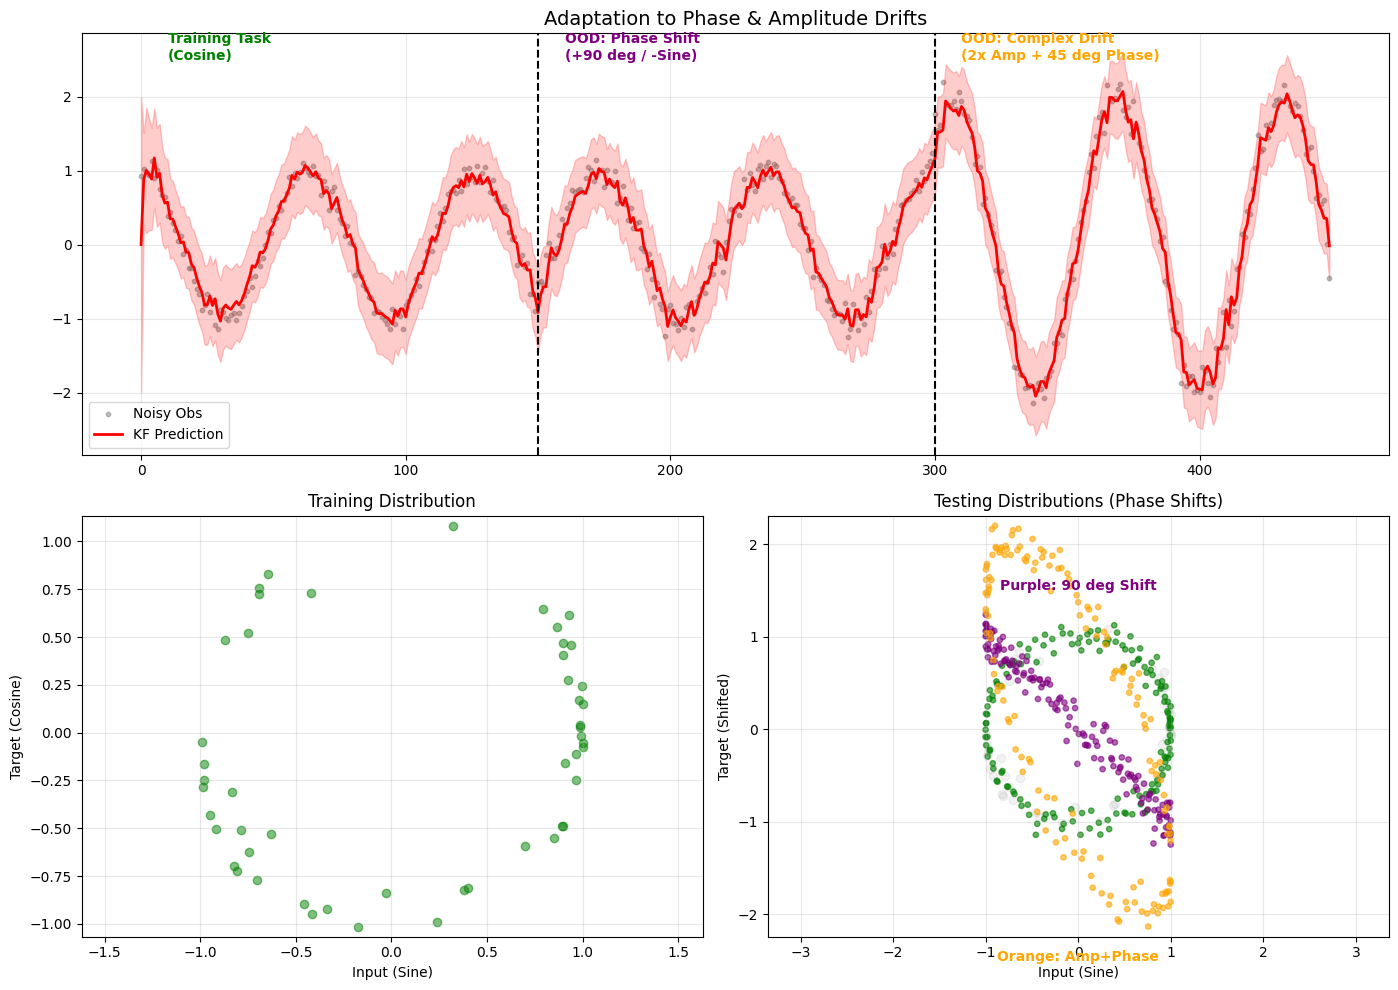

In [ ]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ==========================================
# 1. CONFIGURATION
# ==========================================
TRAIN_NOISE_STD = 0.1
TEST_NOISE_STD = 0.15
SEQ_LEN = 10
HIDDEN_SIZE = 32


# ==========================================
# 2. DATA GENERATION (With Phase Shifts)
# ==========================================
def generate_data_point(t, task_mode="train"):
    """
    Generates data with specific Amplitude and Phase characteristics.
    Input is always sin(0.1t).
    """
    x = np.sin(0.1 * t)

    if task_mode == "train":
        # Standard Cosine (Phase = 0 relative to Cosine)
        # y = 1.0 * cos(0.1t + 0)
        y = np.cos(0.1 * t)
        noise = np.random.normal(0, TRAIN_NOISE_STD)

    elif task_mode == "ood_phase":
        # OOD 1: Pure Phase Shift (90 degrees / pi/2)
        # cos(t + pi/2) = -sin(t)
        # The model must learn to map sin(t) -> -sin(t) instead of -> cos(t)
        y = np.cos(0.1 * t + np.pi / 2)
        noise = np.random.normal(0, TEST_NOISE_STD)

    elif task_mode == "ood_complex":
        # OOD 2: Amplitude AND Phase Shift
        # y = 2.0 * cos(0.1t + pi/4)
        y = 2.0 * np.cos(0.1 * t + np.pi / 4)
        noise = np.random.normal(0, TEST_NOISE_STD)

    return x, y + noise, y


# ==========================================
# 3. MODELS
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, HIDDEN_SIZE, batch_first=True, nonlinearity="tanh")
        self.linear = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        features = out[:, -1, :]
        pred = self.linear(features)
        return pred, features


class KalmanFilterHead:
    def __init__(self, feature_dim, rho=0.98, R_std=0.1):
        self.M = feature_dim
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 5.0
        self.A = np.eye(self.M) * rho
        self.Q = np.eye(self.M) * 0.01
        self.R = np.array([[R_std**2]])

    def step(self, phi, y_obs):
        # Predict
        mu_minus = self.A @ self.mu
        P_minus = self.A @ self.P @ self.A.T + self.Q
        # Measure
        H = phi.T
        y_pred = H @ mu_minus
        # Update
        S = H @ P_minus @ H.T + self.R
        K = P_minus @ H.T @ np.linalg.inv(S)
        self.mu = mu_minus + K * (y_obs - y_pred)
        I_KH = np.eye(self.M) - K @ H
        self.P = I_KH @ P_minus @ I_KH.T + K @ self.R @ K.T
        return y_pred.item(), np.sqrt(S.item())


# ==========================================
# 4. EXPERIMENT
# ==========================================

# --- Phase 1: Pre-train RNN ---
print("Training RNN on Standard Cosine...")
rnn = SimpleRNN()
opt = optim.Adam(rnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_scatter_x, train_scatter_y = [], []

for epoch in range(150):
    inputs, targets = [], []
    for i in range(50):
        t_start = np.random.rand() * 100
        seq_x = []
        for j in range(SEQ_LEN):
            x, y_noisy, _ = generate_data_point(t_start + j, "train")
            seq_x.append([x])
        inputs.append(seq_x)
        targets.append([y_noisy])
        if epoch == 149:
            train_scatter_x.append(seq_x[-1][0])
            train_scatter_y.append(y_noisy)

    x_ten = torch.tensor(inputs, dtype=torch.float32)
    y_ten = torch.tensor(targets, dtype=torch.float32)
    opt.zero_grad()
    pred, _ = rnn(x_ten)
    loss = criterion(pred, y_ten)
    loss.backward()
    opt.step()

print("Freezing Backbone.")
for p in rnn.parameters():
    p.requires_grad = False

# --- Phase 2: Online Test with Phase Shifts ---
print("Starting Online Adaptation...")
kf = KalmanFilterHead(HIDDEN_SIZE, R_std=TEST_NOISE_STD)
buffer = deque(np.zeros(SEQ_LEN), maxlen=SEQ_LEN)

test_history = {"t": [], "y_obs": [], "y_pred": [], "sigma": [], "mode": []}
test_scatter = {"x": [], "y": [], "color": []}

for t in range(450):
    # Define Shifts
    if t < 150:
        mode = "train"  # In-Distribution
        color = "green"
    elif t < 300:
        mode = "ood_phase"  # OOD 1: 90 deg Phase Shift
        color = "purple"
    else:
        mode = "ood_complex"  # OOD 2: Amp + 45 deg Phase
        color = "orange"

    # Get Data
    x_val, y_noisy, y_clean = generate_data_point(t, mode)
    buffer.append(x_val)

    # Forward
    x_ten = torch.tensor([list(buffer)], dtype=torch.float32).unsqueeze(2)
    _, feats = rnn(x_ten)
    phi = feats.numpy().T
    pred, sigma = kf.step(phi, y_noisy)

    # Log
    test_history["t"].append(t)
    test_history["y_obs"].append(y_noisy)
    test_history["y_pred"].append(pred)
    test_history["sigma"].append(sigma)

    test_scatter["x"].append(x_val)
    test_scatter["y"].append(y_noisy)
    test_scatter["color"].append(color)

# ==========================================
# 5. PLOTTING
# ==========================================
plt.figure(figsize=(14, 10))

# --- Time Series ---
plt.subplot(2, 2, (1, 2))
t = test_history["t"]
pred = np.array(test_history["y_pred"])
sigma = np.array(test_history["sigma"])

plt.scatter(t, test_history["y_obs"], c="gray", s=10, alpha=0.5, label="Noisy Obs")
plt.plot(t, pred, "r-", linewidth=2, label="KF Prediction")
plt.fill_between(t, pred - 2 * sigma, pred + 2 * sigma, color="red", alpha=0.2)

plt.axvline(150, linestyle="--", color="k")
plt.text(10, 2.5, "Training Task\n(Cosine)", color="green", fontweight="bold")

plt.axvline(300, linestyle="--", color="k")
plt.text(160, 2.5, "OOD: Phase Shift\n(+90 deg / -Sine)", color="purple", fontweight="bold")
plt.text(310, 2.5, "OOD: Complex Drift\n(2x Amp + 45 deg Phase)", color="orange", fontweight="bold")

plt.title("Adaptation to Phase & Amplitude Drifts", fontsize=14)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# --- Distributions ---
plt.subplot(2, 2, 3)
plt.title("Training Distribution")
plt.scatter(train_scatter_x, train_scatter_y, c="green", alpha=0.5)
plt.xlabel("Input (Sine)")
plt.ylabel("Target (Cosine)")
plt.axis("equal")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.title("Testing Distributions (Phase Shifts)")
plt.scatter(train_scatter_x, train_scatter_y, c="gray", alpha=0.1, label="Train")
plt.scatter(test_scatter["x"], test_scatter["y"], c=test_scatter["color"], s=15, alpha=0.6)
plt.text(0, 1.5, "Purple: 90 deg Shift", color="purple", ha="center", fontweight="bold")
plt.text(0, -2.5, "Orange: Amp+Phase", color="orange", ha="center", fontweight="bold")
plt.xlabel("Input (Sine)")
plt.ylabel("Target (Shifted)")
plt.axis("equal")
plt.grid(True, alpha=0.3)
plt.savefig("OOD_train.png", dpi=300)
plt.tight_layout()
plt.show()

<>:199: SyntaxWarning: invalid escape sequence '\s'
<>:199: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1297163111.py:199: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(t, pred - 2*sigma, pred + 2*sigma, color='red', alpha=0.15, label='Uncertainty (2$\sigma$)')


Pre-training Sequential Backbone...
Starting Simulation: Train -> Deployment (No Labels)...


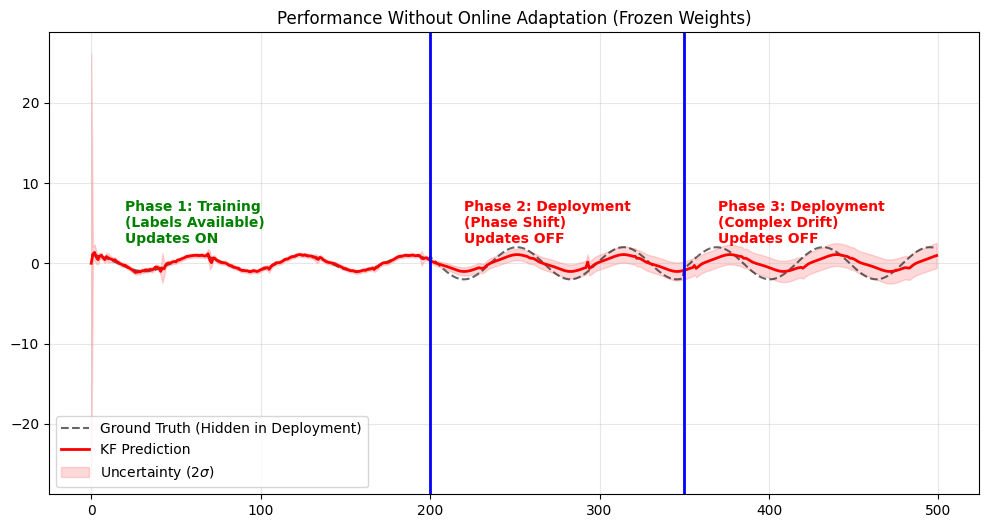

In [ ]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ==========================================
# 1. CONFIGURATION
# ==========================================
SEQ_LEN = 10
HIDDEN_SIZE = 32
# We turn off noise for the "Truth" plotting to clearly see the drift
NOISE_STD = 0.1


# ==========================================
# 2. DATA GENERATION (Phase & Amplitude Drifts)
# ==========================================
def generate_data_point(t, task_mode="train"):
    x = np.sin(0.1 * t)

    if task_mode == "train":
        # Task 1: Standard Cosine
        y_clean = np.cos(0.1 * t)
    elif task_mode == "ood_phase":
        # Task 2: 90 degree Phase Shift (-Sine)
        y_clean = 2 * np.cos(0.1 * t)
    elif task_mode == "ood_complex":
        # Task 3: Amplitude x2 + Phase Shift
        y_clean = 2.0 * np.cos(0.1 * t + np.pi / 4)

    # Add noise to observation
    y_noisy = y_clean + np.random.normal(0, NOISE_STD)
    return x, y_noisy, y_clean


# ==========================================
# 3. MODELS
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Impose Sequential Structure [cite: 127]
        self.rnn = nn.RNN(1, HIDDEN_SIZE, batch_first=True, nonlinearity="tanh")
        self.linear = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        features = out[:, -1, :]  # Extract feature vector phi_t
        pred = self.linear(features)
        return pred, features


class KalmanFilterHead:
    def __init__(self, feature_dim, rho=1.0, Q_std=0.005, R_std=0.1):
        self.M = feature_dim
        # Impose State Space Model [cite: 15-17]
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 10.0
        self.A = np.eye(self.M) * rho  # State Transition
        self.Q = np.eye(self.M) * (Q_std**2)  # Process Noise
        self.R = np.array([[R_std**2]])  # Measurement Noise

    def predict(self, phi):
        """
        Time Update Step (Always runs)
        """
        # 1. Project State (Drift) [cite: 26]
        self.mu_minus = self.A @ self.mu

        # 2. Project Uncertainty [cite: 29]
        # Uncertainty grows because we add Process Noise Q
        self.P_minus = self.A @ self.P @ self.A.T + self.Q

        # 3. Predict Measurement [cite: 30]
        self.H = phi.T
        y_pred = self.H @ self.mu_minus
        return y_pred.item()

    def update(self, y_obs):
        """
        Measurement Update Step (Runs only when labels exist)
        """
        # [cite: 32-41]
        S = self.H @ self.P_minus @ self.H.T + self.R
        K = self.P_minus @ self.H.T @ np.linalg.inv(S)

        self.mu = self.mu_minus + K * (y_obs - (self.H @ self.mu_minus))
        I_KH = np.eye(self.M) - K @ self.H
        self.P = I_KH @ self.P_minus @ I_KH.T + K @ self.R @ K.T

        return np.sqrt(S.item())

    def get_uncertainty(self):
        # Calculate hypothetical S (Innovation variance) without updating
        # This tells us how uncertain we *would* be
        S = self.H @ self.P_minus @ self.H.T + self.R
        return np.sqrt(S.item())


# ==========================================
# 4. EXPERIMENT
# ==========================================

# --- Phase A: Pre-train RNN (Offline) ---
print("Pre-training Sequential Backbone...")
rnn = SimpleRNN()
opt = optim.Adam(rnn.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(100):
    inputs, targets = [], []
    for i in range(50):  # Batch size
        t_start = np.random.rand() * 100
        seq_x = []
        for j in range(SEQ_LEN):
            x, y_n, _ = generate_data_point(t_start + j, "train")
            seq_x.append([x])
        inputs.append(seq_x)
        targets.append([y_n])

    x_ten = torch.tensor(inputs, dtype=torch.float32)
    y_ten = torch.tensor(targets, dtype=torch.float32)
    opt.zero_grad()
    pred, _ = rnn(x_ten)
    loss = criterion(pred, y_ten)
    loss.backward()
    opt.step()

# Freeze RNN
for p in rnn.parameters():
    p.requires_grad = False

# --- Phase B: Online Simulation ---
print("Starting Simulation: Train -> Deployment (No Labels)...")
kf = KalmanFilterHead(HIDDEN_SIZE, rho=1.0, Q_std=0.01)  # rho=1.0 = Random Walk
buffer = deque(np.zeros(SEQ_LEN), maxlen=SEQ_LEN)

history = {"t": [], "truth": [], "pred": [], "sigma": [], "mode": []}

# Simulation Loop
for t in range(500):
    # 1. Determine Task
    if t < 200:
        mode = "train"  # Task 1: Standard
        update_weights = True  # We have labels!
    elif t < 350:
        mode = "ood_phase"  # Task 2: Phase Shift
        update_weights = False  # NO LABELS ("Real Life")
    else:
        mode = "ood_complex"  # Task 3: Complex
        update_weights = False  # NO LABELS

    # 2. Get Data
    x_val, y_noisy, y_clean = generate_data_point(t, mode)
    buffer.append(x_val)

    # 3. Backbone (Sequential)
    x_ten = torch.tensor([list(buffer)], dtype=torch.float32).unsqueeze(2)
    _, feats = rnn(x_ten)
    phi = feats.numpy().T

    # 4. Head (State Space)
    # ALWAYS Predict (Time Update)
    pred = kf.predict(phi)

    if update_weights:
        # Update weights using label
        sigma = kf.update(y_noisy)
    else:
        # Do NOT update weights (Deployment mode)
        # Just calculate uncertainty based on current covariance growth
        sigma = kf.get_uncertainty()

        # IMPORTANT: Because we didn't update, we must carry over the
        # predicted covariance/mean to the next step as the "current" state
        # so the uncertainty accumulation persists.
        kf.mu = kf.mu_minus
        kf.P = kf.P_minus

    # Log
    history["t"].append(t)
    history["truth"].append(y_clean)
    history["pred"].append(pred)
    history["sigma"].append(sigma)
    history["mode"].append(mode)

# ==========================================
# 5. PLOTTING
# ==========================================
t = history["t"]
truth = np.array(history["truth"])
pred = np.array(history["pred"])
sigma = np.array(history["sigma"])

plt.figure(figsize=(12, 6))

# Plot Trajectories
plt.plot(t, truth, "k--", label="Ground Truth (Hidden in Deployment)", alpha=0.6)
plt.plot(t, pred, "r-", linewidth=2, label="KF Prediction")

# Plot Uncertainty
plt.fill_between(
    t, pred - 2 * sigma, pred + 2 * sigma, color="red", alpha=0.15, label=r"Uncertainty (2$\sigma$)"
)

# Visual Formatting
plt.axvline(200, color="blue", linestyle="-", linewidth=2)
plt.text(
    20, 2.5, "Phase 1: Training\n(Labels Available)\nUpdates ON", color="green", fontweight="bold"
)
plt.text(
    220, 2.5, "Phase 2: Deployment\n(Phase Shift)\nUpdates OFF", color="red", fontweight="bold"
)
plt.axvline(350, color="blue", linestyle="-", linewidth=2)
plt.text(
    370, 2.5, "Phase 3: Deployment\n(Complex Drift)\nUpdates OFF", color="red", fontweight="bold"
)

plt.title("Performance Without Online Adaptation (Frozen Weights)")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

<>:140: SyntaxWarning: invalid escape sequence '\s'
<>:147: SyntaxWarning: invalid escape sequence '\s'
<>:151: SyntaxWarning: invalid escape sequence '\s'
<>:140: SyntaxWarning: invalid escape sequence '\s'
<>:147: SyntaxWarning: invalid escape sequence '\s'
<>:151: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1986900064.py:140: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Trajectory with ±1$\sigma$ Uncertainty (Updates DISABLED after t=150)")
/tmp/ipython-input-1986900064.py:147: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(t, kf_pred - kf_sigma, kf_pred + kf_sigma, color='red', alpha=0.2, label='KF Uncertainty (±1$\sigma$)')
/tmp/ipython-input-1986900064.py:151: SyntaxWarning: invalid escape sequence '\s'
  plt.fill_between(t, blr_pred - blr_sigma, blr_pred + blr_sigma, color='blue', alpha=0.2, label='BLR Uncertainty (±1$\sigma$)')


Running Simulation...


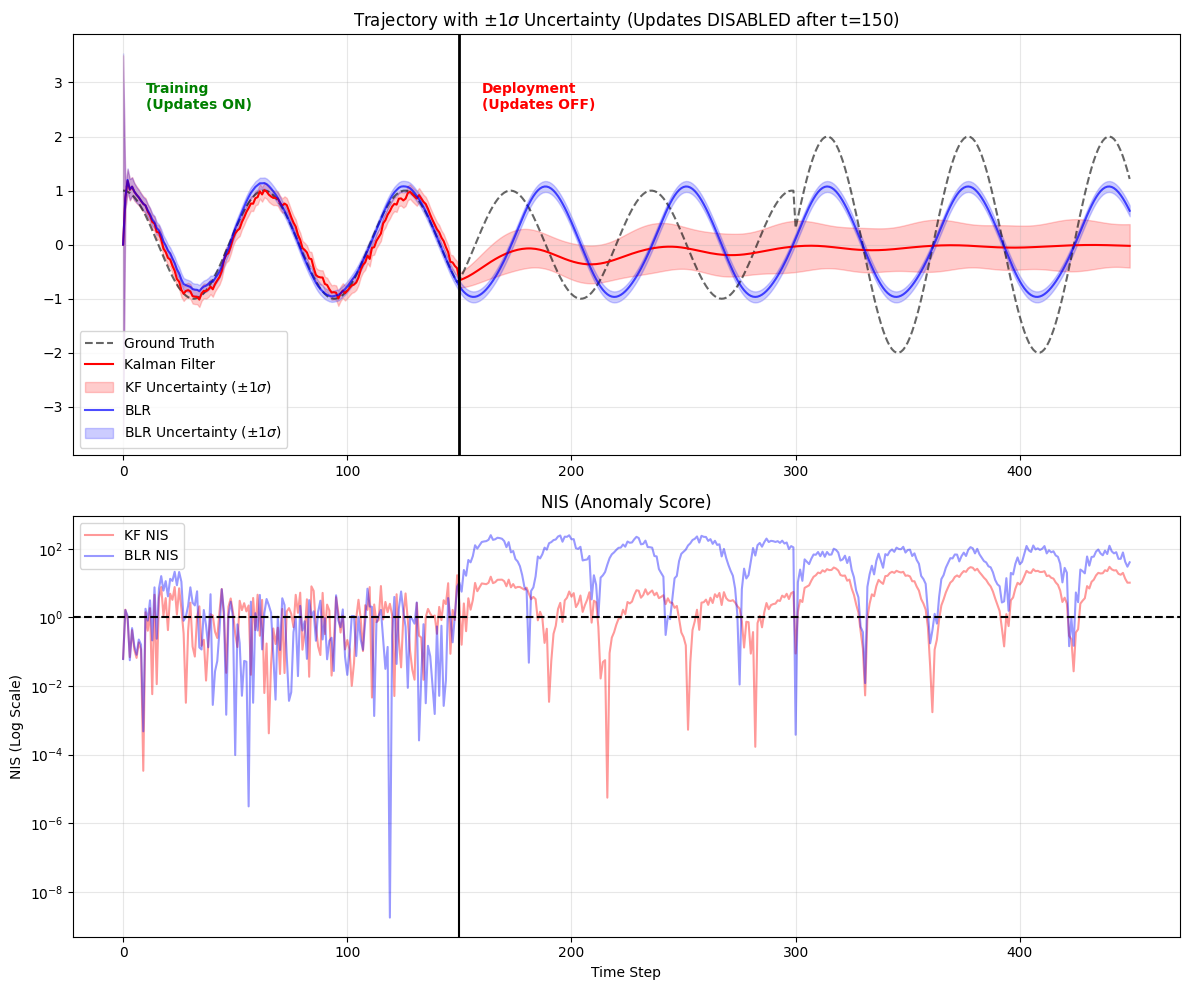

In [ ]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

# ==========================================
# 1. CONFIGURATION
# ==========================================
SEQ_LEN = 10
HIDDEN_SIZE = 32
NOISE_STD = 0.1
STEPS = 450


# ==========================================
# 2. DATA GENERATION
# ==========================================
def generate_data(t, task_mode):
    x = np.sin(0.1 * t)
    if task_mode == "train":
        y = np.cos(0.1 * t)  # Task 1: Cosine
    elif task_mode == "ood_phase":
        y = np.cos(0.1 * t + np.pi / 2)  # Task 2: Phase Shift
    elif task_mode == "ood_amp":
        y = 2.0 * np.cos(0.1 * t)  # Task 3: Amplitude Shift

    y_noisy = y + np.random.normal(0, NOISE_STD)
    return x, y_noisy, y


# ==========================================
# 3. MODELS
# ==========================================
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, HIDDEN_SIZE, batch_first=True, nonlinearity="tanh")
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        out, _ = self.rnn(x)
        return out[:, -1, :]


class BayesianLastLayer:
    def __init__(self, feature_dim, model_type="KF", Q_std=0.01, R_std=0.1):
        self.M = feature_dim
        self.model_type = model_type

        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 10.0
        self.R = np.array([[R_std**2]])

        if model_type == "KF":
            self.A = np.eye(self.M) * 0.99
            self.Q = np.eye(self.M) * (Q_std**2)
        else:
            self.A = np.eye(self.M)
            self.Q = np.zeros((self.M, self.M))

    def step(self, phi, y_obs, update_weights=True):
        # 1. Predict (Time Update)
        mu_minus = self.A @ self.mu
        P_minus = self.A @ self.P @ self.A.T + self.Q

        # 2. Measure (Prediction)
        H = phi.T
        y_pred = H @ mu_minus

        # Innovation Covariance S (Predictive Variance)
        S = H @ P_minus @ H.T + self.R
        sigma = np.sqrt(S.item())  # Extract Sigma

        error = y_obs - y_pred
        nis = (error**2) / S

        # 3. Update (Measurement Update)
        if update_weights:
            K = P_minus @ H.T @ np.linalg.inv(S)
            self.mu = mu_minus + K * error
            I_KH = np.eye(self.M) - K @ H
            self.P = I_KH @ P_minus @ I_KH.T + K @ self.R @ K.T
        else:
            # Propagate drift only
            self.mu = mu_minus
            self.P = P_minus

        return y_pred.item(), nis.item(), sigma


# ==========================================
# 4. EXPERIMENT
# ==========================================

rnn = SimpleRNN()
kf = BayesianLastLayer(HIDDEN_SIZE, model_type="KF", Q_std=0.05)
blr = BayesianLastLayer(HIDDEN_SIZE, model_type="BLR")

buffer = deque(np.zeros(SEQ_LEN), maxlen=SEQ_LEN)
hist = {
    "t": [],
    "truth": [],
    "kf_pred": [],
    "kf_sigma": [],
    "kf_nis": [],
    "blr_pred": [],
    "blr_sigma": [],
    "blr_nis": [],
}

print("Running Simulation...")

for t in range(STEPS):
    if t < 150:
        mode = "train"
        do_update = True
    elif t < 300:
        mode = "ood_phase"
        do_update = False
    else:
        mode = "ood_amp"
        do_update = False

    x, y_n, y_c = generate_data(t, mode)
    buffer.append(x)

    x_ten = torch.tensor([list(buffer)], dtype=torch.float32).unsqueeze(2)
    phi = rnn(x_ten).numpy().T

    # Step with extraction of sigma
    kf_y, kf_nis, kf_sigma = kf.step(phi, y_n, update_weights=do_update)
    blr_y, blr_nis, blr_sigma = blr.step(phi, y_n, update_weights=do_update)

    # Log
    hist["t"].append(t)
    hist["truth"].append(y_c)
    hist["kf_pred"].append(kf_y)
    hist["kf_sigma"].append(kf_sigma)
    hist["kf_nis"].append(kf_nis)
    hist["blr_pred"].append(blr_y)
    hist["blr_sigma"].append(blr_sigma)
    hist["blr_nis"].append(blr_nis)

# ==========================================
# 5. PLOTTING
# ==========================================
t = np.array(hist["t"])
kf_pred = np.array(hist["kf_pred"])
kf_sigma = np.array(hist["kf_sigma"])
blr_pred = np.array(hist["blr_pred"])
blr_sigma = np.array(hist["blr_sigma"])

plt.figure(figsize=(12, 10))

# --- Plot 1: Trajectory with Uncertainty ---
plt.subplot(2, 1, 1)
plt.title(r"Trajectory with ±1$\sigma$ Uncertainty (Updates DISABLED after t=150)")

# Ground Truth
plt.plot(t, hist["truth"], "k--", label="Ground Truth", alpha=0.6)

# Kalman Filter (Red)
plt.plot(t, kf_pred, "r-", label="Kalman Filter")
plt.fill_between(
    t,
    kf_pred - kf_sigma,
    kf_pred + kf_sigma,
    color="red",
    alpha=0.2,
    label=r"KF Uncertainty (±1$\sigma$)",
)

# BLR (Blue)
plt.plot(t, blr_pred, "b-", label="BLR", alpha=0.7)
plt.fill_between(
    t,
    blr_pred - blr_sigma,
    blr_pred + blr_sigma,
    color="blue",
    alpha=0.2,
    label=r"BLR Uncertainty (±1$\sigma$)",
)

# Formatting
plt.axvline(150, color="k", linewidth=2)
plt.text(10, 2.5, "Training\n(Updates ON)", color="green", fontweight="bold")
plt.text(160, 2.5, "Deployment\n(Updates OFF)", color="red", fontweight="bold")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)

# --- Plot 2: NIS ---
plt.subplot(2, 1, 2)
plt.title("NIS (Anomaly Score)")
plt.semilogy(t, hist["kf_nis"], "r", alpha=0.4, label="KF NIS")
plt.semilogy(t, hist["blr_nis"], "b", alpha=0.4, label="BLR NIS")
plt.axhline(1.0, color="k", linestyle="--")
plt.axvline(150, color="k")
plt.ylabel("NIS (Log Scale)")
plt.xlabel("Time Step")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Generating data stream...


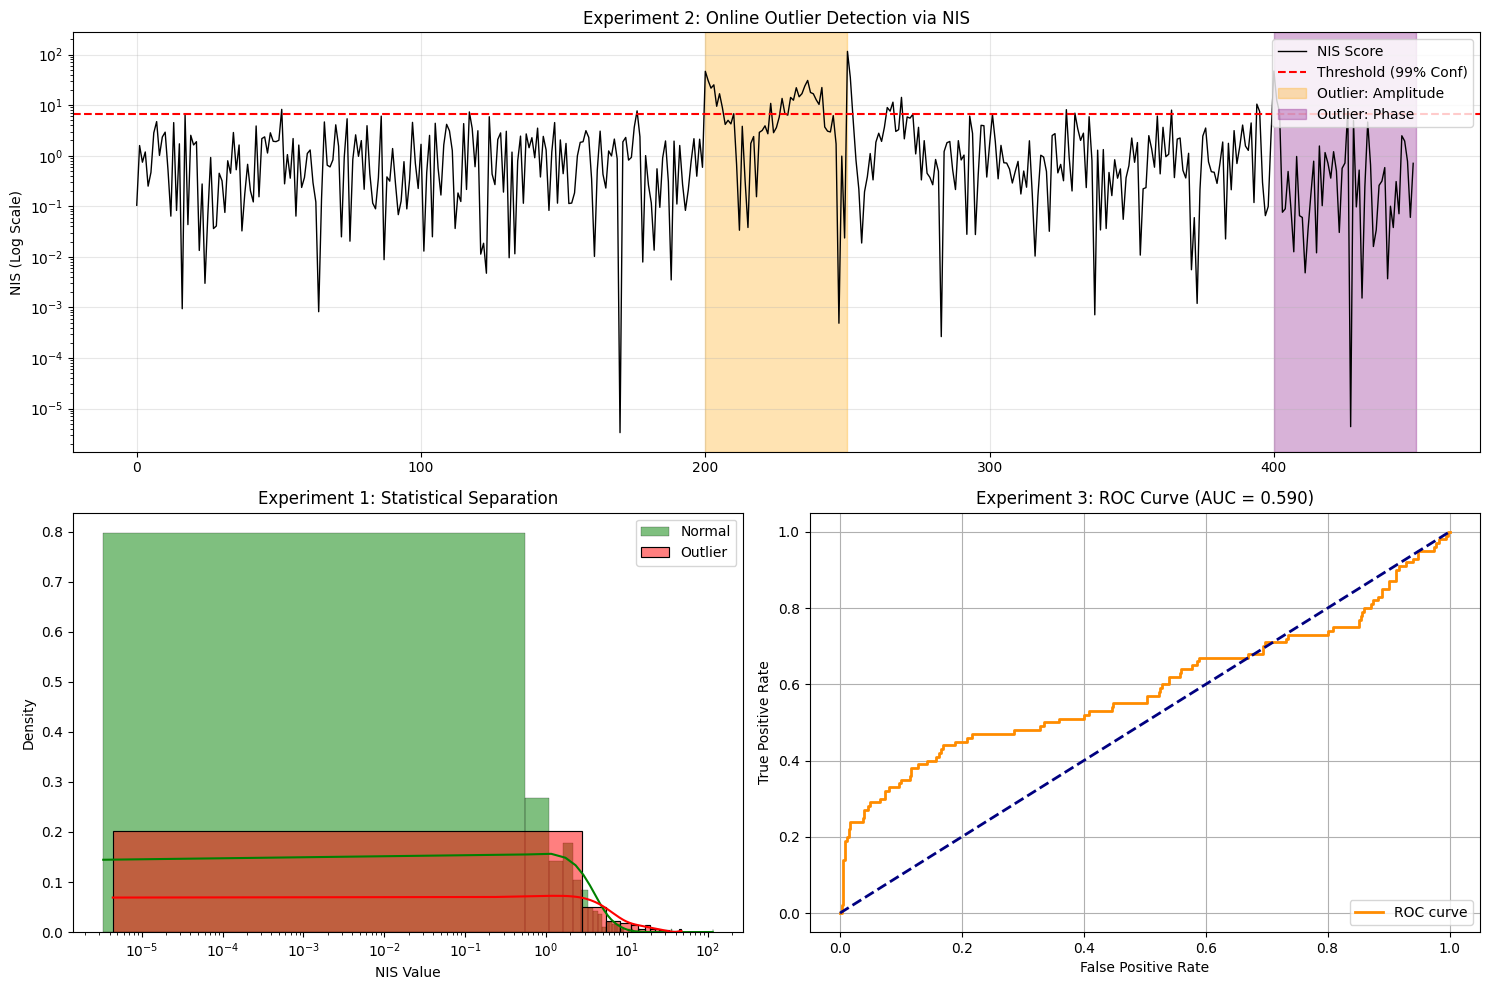

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import auc, roc_curve

# ==========================================
# 1. SETUP
# ==========================================
SEQ_LEN = 10
HIDDEN_SIZE = 32
NOISE_STD = 0.1


# Standard RNN Backbone (Frozen)
class SimpleRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, HIDDEN_SIZE, batch_first=True, nonlinearity="tanh")
        # Pre-defined random weights to simulate a "fitted" feature extractor
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        out, _ = self.rnn(x)
        return out[:, -1, :]


# Kalman Filter Head (The Detector)
class KalmanDetector:
    def __init__(self, feature_dim):
        self.M = feature_dim
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 10.0
        self.A = np.eye(self.M) * 0.99
        self.Q = np.eye(self.M) * 0.01
        self.R = np.array([[0.1**2]])  # Matches expected noise

    def check_input(self, phi, y_obs):
        # 1. Predict
        mu_minus = self.A @ self.mu
        P_minus = self.A @ self.P @ self.A.T + self.Q

        # 2. Calculate NIS (The Anomaly Score)
        H = phi.T
        y_pred = H @ mu_minus
        error = y_obs - y_pred
        S = H @ P_minus @ H.T + self.R

        nis = (error**2) / S

        # 3. Update (We update even if outlier to try to adapt,
        # or we could choose to freeze if NIS is too high)
        K = P_minus @ H.T @ np.linalg.inv(S)
        self.mu = mu_minus + K * error
        I_KH = np.eye(self.M) - K @ H
        self.P = I_KH @ P_minus @ I_KH.T + K @ self.R @ K.T

        return nis.item()


# Data Generator
def get_sequence(t, type="normal"):
    # Input x is always sine
    x_seq = np.sin(0.1 * np.arange(t, t + SEQ_LEN)).reshape(-1, 1)

    if type == "normal":
        y = np.cos(0.1 * (t + SEQ_LEN - 1))
    elif type == "outlier_amp":
        y = 3.0 * np.cos(0.1 * (t + SEQ_LEN - 1))  # Amplitude Spike
    elif type == "outlier_phase":
        y = np.cos(0.1 * (t + SEQ_LEN - 1) + np.pi / 2)  # Inversion

    y_noisy = y + np.random.normal(0, NOISE_STD)
    return torch.tensor(x_seq, dtype=torch.float32).unsqueeze(0), y_noisy


# ==========================================
# 2. RUN EXPERIMENTS
# ==========================================
rnn = SimpleRNN()
detector = KalmanDetector(HIDDEN_SIZE)

nis_scores = []
labels = []  # 0 for Normal, 1 for Outlier

print("Generating data stream...")

# A. Normal Phase (Calibration)
for t in range(200):
    x, y = get_sequence(t, "normal")
    phi = rnn(x).numpy().T
    score = detector.check_input(phi, y)
    nis_scores.append(score)
    labels.append(0)

# B. Outlier Phase (Attack!)
for t in range(200, 250):
    x, y = get_sequence(t, "outlier_amp")  # Huge amplitude shift
    phi = rnn(x).numpy().T
    score = detector.check_input(phi, y)
    nis_scores.append(score)
    labels.append(1)

# C. Recovery Phase (Normal)
for t in range(250, 400):
    x, y = get_sequence(t, "normal")
    phi = rnn(x).numpy().T
    score = detector.check_input(phi, y)
    nis_scores.append(score)
    labels.append(0)

# D. Outlier Phase 2 (Subtle)
for t in range(400, 450):
    x, y = get_sequence(t, "outlier_phase")  # Phase shift
    phi = rnn(x).numpy().T
    score = detector.check_input(phi, y)
    nis_scores.append(score)
    labels.append(1)

# ==========================================
# 3. VISUALIZATION
# ==========================================
plt.figure(figsize=(15, 10))

# Plot 1: The Online Monitor
plt.subplot(2, 2, (1, 2))
plt.title("Experiment 2: Online Outlier Detection via NIS")
plt.plot(nis_scores, "k-", linewidth=1, label="NIS Score")
# Detection Threshold (e.g., Chi-square p=0.01 cutoff is approx 6.6 for 1 dof)
threshold = 6.6
plt.axhline(threshold, color="red", linestyle="--", label="Threshold (99% Conf)")

# Highlight Regions
plt.axvspan(200, 250, color="orange", alpha=0.3, label="Outlier: Amplitude")
plt.axvspan(400, 450, color="purple", alpha=0.3, label="Outlier: Phase")

plt.yscale("log")  # Log scale is CRITICAL for NIS
plt.ylabel("NIS (Log Scale)")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)

# Plot 2: Histograms (Statistical Separation)
plt.subplot(2, 2, 3)
plt.title("Experiment 1: Statistical Separation")
scores_normal = [s for s, l in zip(nis_scores, labels, strict=False) if l == 0]
scores_outlier = [s for s, l in zip(nis_scores, labels, strict=False) if l == 1]

sns.histplot(scores_normal, color="green", label="Normal", kde=True, stat="density")
sns.histplot(scores_outlier, color="red", label="Outlier", kde=True, stat="density")
plt.xscale("log")
plt.xlabel("NIS Value")
plt.legend()

# Plot 3: ROC Curve (Classification Performance)
plt.subplot(2, 2, 4)
fpr, tpr, _ = roc_curve(labels, nis_scores)
roc_auc = auc(fpr, tpr)

plt.title(f"Experiment 3: ROC Curve (AUC = {roc_auc:.3f})")
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

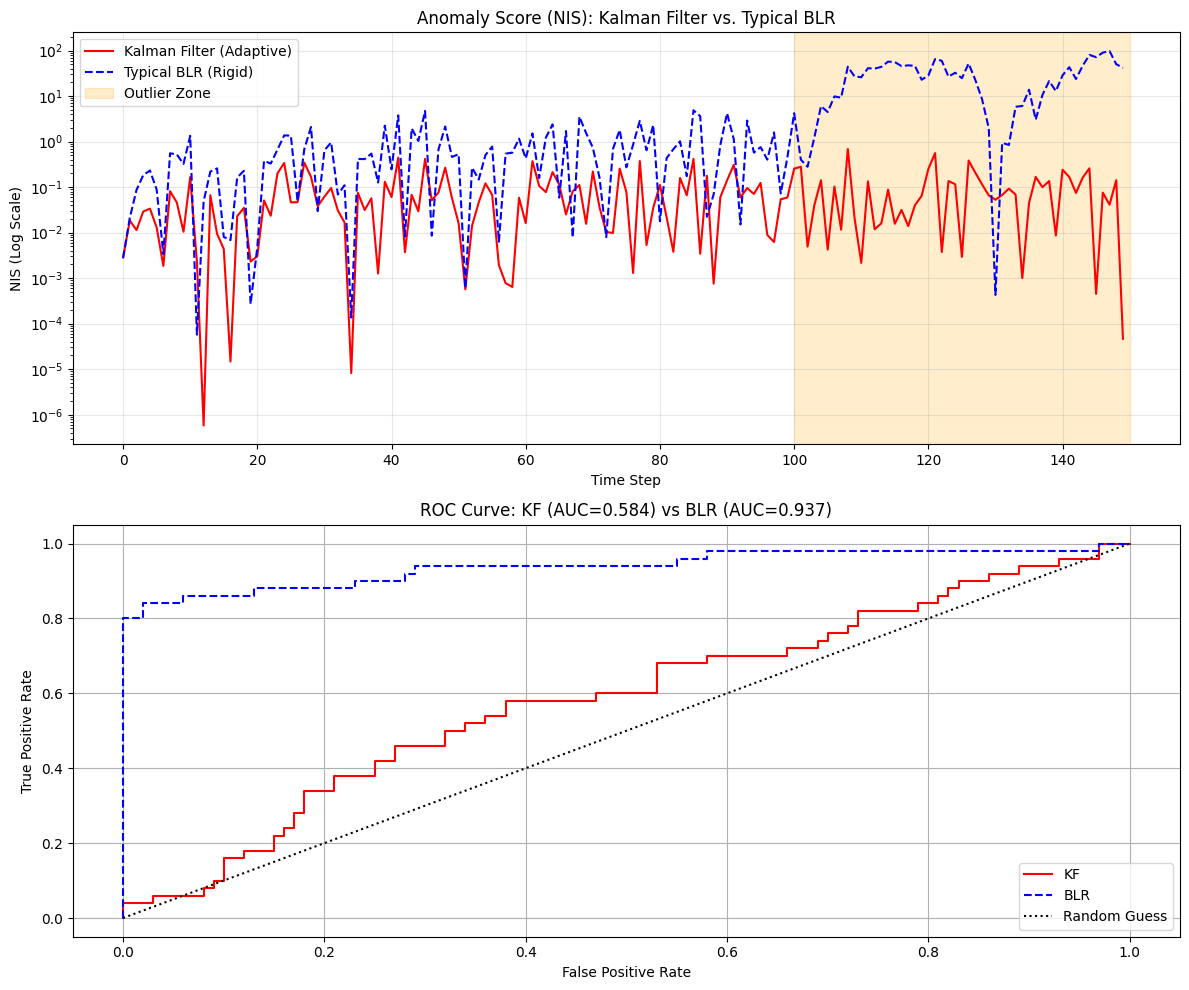

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_curve

# ==========================================
# 1. SETUP & MODEL DEFINITIONS
# ==========================================
SEQ_LEN = 10
HIDDEN_SIZE = 32
NOISE_STD = 0.1

# --- The Backbone (Frozen Feature Extractor) ---
# We simulate a "fitted" RNN using a fixed random projection.
# This ensures both models see identical features.
np.random.seed(42)
W_proj = np.random.randn(HIDDEN_SIZE, SEQ_LEN)
b_proj = np.random.randn(HIDDEN_SIZE, 1)


def get_features(window):
    # Input: Window of 10 sine values
    x = np.array(window).reshape(SEQ_LEN, 1)
    # Linear Projection -> Tanh Activation
    z = np.tanh(W_proj @ x + b_proj)
    return z  # Feature vector (phi)


# --- The Bayesian Last Layer ---
class BayesianDetector:
    def __init__(self, feature_dim, mode="KF"):
        self.M = feature_dim
        self.mode = mode

        # Initial Belief State (Mean & Covariance)
        self.mu = np.zeros((self.M, 1))
        self.P = np.eye(self.M) * 10.0
        self.R = np.array([[0.1**2]])  # Expected measurement noise

        if mode == "KF":
            # Kalman Filter:
            # Weights are "Plastic" (Drift allowed via Q)
            self.A = np.eye(self.M) * 0.99
            self.Q = np.eye(self.M) * 0.01
        else:
            # Typical BLR:
            # Weights are "Rigid" (Static, Q=0)
            self.A = np.eye(self.M)
            self.Q = np.zeros((self.M, self.M))

    def step(self, phi, y_obs):
        # 1. Predict (Time Update)
        mu_minus = self.A @ self.mu
        P_minus = self.A @ self.P @ self.A.T + self.Q  # BLR adds 0 here

        # 2. Calculate NIS (Anomaly Score)
        H = phi.T
        y_pred = H @ mu_minus
        error = y_obs - y_pred

        # Innovation Covariance S (Uncertainty of this specific prediction)
        S = H @ P_minus @ H.T + self.R

        # NIS = Squared Error / Uncertainty
        nis = (error**2) / S

        # 3. Update (Measurement Update)
        # We update the model even during outliers to see if it "adapts"
        K = P_minus @ H.T @ np.linalg.inv(S)
        self.mu = mu_minus + K * error
        I_KH = np.eye(self.M) - K @ H
        self.P = I_KH @ P_minus @ I_KH.T + K @ self.R @ K.T

        return nis.item()


# --- Data Generator ---
def get_data_point(t, type="normal"):
    # Generate input window (Sine)
    window = np.sin(0.1 * np.arange(t, t + SEQ_LEN))

    if type == "normal":
        # Normal Target: Cosine
        y = np.cos(0.1 * (t + SEQ_LEN - 1))
    elif type == "outlier":
        # Outlier Target: 2x Amplitude
        y = 2.0 * np.cos(0.1 * (t + SEQ_LEN - 1))

    y_noisy = y + np.random.normal(0, NOISE_STD)
    return window, y_noisy


# ==========================================
# 2. EXECUTE COMPARISON
# ==========================================
kf = BayesianDetector(HIDDEN_SIZE, mode="KF")
blr = BayesianDetector(HIDDEN_SIZE, mode="BLR")

kf_scores, blr_scores, labels = [], [], []

# Phase A: Calibration (Steps 0-100)
for t in range(100):
    x, y = get_data_point(t, "normal")
    phi = get_features(x)

    kf_scores.append(kf.step(phi, y))
    blr_scores.append(blr.step(phi, y))
    labels.append(0)

# Phase B: Outlier Event (Steps 100-150)
for t in range(100, 150):
    x, y = get_data_point(t, "outlier")
    phi = get_features(x)

    kf_scores.append(kf.step(phi, y))
    blr_scores.append(blr.step(phi, y))
    labels.append(1)

# ==========================================
# 3. PLOTTING
# ==========================================
plt.figure(figsize=(12, 10))

# Plot 1: NIS Score Evolution
plt.subplot(2, 1, 1)
plt.title("Anomaly Score (NIS): Kalman Filter vs. Typical BLR")
plt.plot(kf_scores, "r-", label="Kalman Filter (Adaptive)")
plt.plot(blr_scores, "b--", label="Typical BLR (Rigid)")
plt.axvspan(100, 150, color="orange", alpha=0.2, label="Outlier Zone")

# Log scale is crucial because BLR errors explode to 10^4+
plt.yscale("log")
plt.ylabel("NIS (Log Scale)")
plt.xlabel("Time Step")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: ROC Curve Analysis
plt.subplot(2, 1, 2)
fpr_kf, tpr_kf, _ = roc_curve(labels, kf_scores)
fpr_blr, tpr_blr, _ = roc_curve(labels, blr_scores)
auc_kf = auc(fpr_kf, tpr_kf)
auc_blr = auc(fpr_blr, tpr_blr)

plt.title(f"ROC Curve: KF (AUC={auc_kf:.3f}) vs BLR (AUC={auc_blr:.3f})")
plt.plot(fpr_kf, tpr_kf, "r-", label="KF")
plt.plot(fpr_blr, tpr_blr, "b--", label="BLR")
plt.plot([0, 1], [0, 1], "k:", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()